# Preliminary

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import minimize

# environment

In [11]:
class LinearMDP_train():
    def __init__(self, action_space, delta, xi_norm, seed=1):
        np.random.seed(seed)
        self.state_space = ['x1', 'x2', 'x3', 'x4', 'x5']
        self.action_space = action_space
        self.initial_state = 'x1'
        self.theta = [np.zeros(4),
                      np.array([0,0,0,1]),
                      np.array([0,0,0,1])]
        self.delta = delta
        self.H = 3
        Xi = np.full(len(self.action_space[0]), 1)
        self.Xi = xi_norm * Xi / np.linalg.norm(Xi, 1)

    def reset(self):
        self.S = [self.initial_state]
        self.A = [] # save the action history
        self.R = [] # save the reward history
        self.h = 0 # reset the step to 0
        self.feature = [] # save the feature trajectory
        self.feature_a = [] # save the full feature trajectory
        self.current_state = self.initial_state # reset the current state to initial state

    def phi(self, current_state, A):
        if current_state == 'x1':
            phi = np.array([1 - self.delta - self.Xi @ A, 0, 0, self.delta + self.Xi @ A])
        elif current_state == 'x2':
            phi = np.array([0, 1 - self.delta - self.Xi @ A, 0, self.delta + self.Xi @ A])
        elif current_state == 'x3':
            phi = np.array([0, 0, 1 - self.delta - self.Xi @ A, self.delta + self.Xi @ A])
        elif current_state == 'x4':
            phi = np.array([0, 0, 1, 0])
        else:
            phi = np.array([0, 0, 0, 1])
        return phi

    def add_state(self, s):
        self.S.append(s)
        self.current_state = s

    def update_state(self, phi, h):
        # calculate the transition probability
        if h == 0:
            prob = [phi[0] * (1 - 0.001), 0, phi[0] * 0.001, phi[3]]
        elif h == 1:
            if phi[2] == 1:
                prob = [0, 0, 1, 0]
            elif phi[3] == 1:
                prob = [0, 0, 0, 1]
            else:
                prob = [0, phi[1] * (1 - 0.001), phi[1] * 0.001, phi[3]]
        else:
            prob = [0, 0, phi[2], phi[3]]
        sprime = np.random.choice(range(1,5), size = 1, p = prob)[0]
        return self.state_space[sprime] # return a string
    
    def next_state(self, phi):
        next_state = self.update_state(phi, self.h)
        self.add_state(next_state)
        return next_state
    
    def generate_reward(self, phi):
        reward = np.dot(phi, self.theta[self.h])
        self.R.append(reward)
        return reward
    
    def step(self, a):
        self.A.append(a)
        phi = self.phi(self.current_state, a)
        phi_a = [self.phi(self.current_state, a) for a in self.action_space]
        self.feature.append(phi)
        self.feature_a.append(phi_a)
        self.generate_reward(phi)
        self.next_state(phi)
        self.h += 1
        

class LinearMDP_test():
    """Perturbed evironment"""
    def __init__(self,  nominal_MDP, q, seed=1):
        np.random.seed(seed)
        self.state_space = nominal_MDP.state_space
        self.action_space = nominal_MDP.action_space
        self.initial_state = 'x1'
        self.theta = nominal_MDP.theta
        self.delta = nominal_MDP.delta
        self.Xi = nominal_MDP.Xi
        self.H = 3
        self.q = q

    def reset(self):
        self.S = [self.initial_state] # save the feature trajectory
        self.A = [] # save the action history
        self.R = [] # save the reward history
        self.h = 0 # reset the step to 0
        self.feature = [] # save the feature trajectory
        self.feature_a = [] # save the full feature trajectory
        self.current_state = self.initial_state # reset the current  state to initial state

    def phi(self, current_state, A):
        if current_state == 'x1':
            phi = np.array([1 - self.delta - self.Xi @ A, 0, 0, self.delta + self.Xi @ A])
        elif current_state == 'x2':
            phi = np.array([0, 1 - self.delta - self.Xi @ A, 0, self.delta + self.Xi @ A])
        elif current_state == 'x3':
            phi = np.array([0, 0, 1 - self.delta - self.Xi @ A, self.delta + self.Xi @ A])
        elif current_state == 'x4':
            phi = np.array([0,0,1,0])
        else:
            phi = np.array([0,0,0,1])
        return phi
    
    def add_state(self, s): 
        self.S.append(s)
        self.current_state = s

    def update_state(self, phi, h):
        # calculate the transition probability  --- perturbed
        if  h == 0:
            prob = [phi[0], 0, self.q * phi[3], (1 - self.q) * phi[3]]
        elif h == 1:
            if phi[2] == 1:
                prob = [0, 0, 1, 0]
            elif phi[3] == 1:
                prob = [0, 0, 0, 1]
            else:
                prob = [0, phi[1] * (1 - 0.001), phi[1] * 0.001, phi[3]]
        else:
            prob =  [0, 0, phi[2], phi[3]]
        sprime = np.random.choice(range(1,5), size = 1, p = prob)[0]
        return self.state_space[sprime] # return a string
    
    def next_state(self, phi):
        next_state = self.update_state(phi, self.h)
        self.add_state(next_state)
        return next_state
    
    def generate_reward(self, phi):
        reward = np.dot(phi, self.theta[self.h])
        self.R.append(reward)
        return reward

    def step(self, a):
        self.A.append(a)
        phi = self.phi(self.current_state, a)
        phi_a = [self.phi(self.current_state, a) for a in self.action_space]
        self.feature.append(phi)
        self.feature_a.append(phi_a)
        self.generate_reward(phi)
        self.next_state(phi)
        self.h += 1

# algorithms

In [12]:
class meta_algorithm():
    def __init__(self, A, beta, H, lam, dataset, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.fail_state = fail_state
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.dataset = dataset
    
    def get_action(self, phi_a, h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range (len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]
    
    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            Q_h = np.min([(self.w[h] @ phi - self.beta * np.sqrt(phi @ Lambda_h_inverse @ phi)), self.H])
            return Q_h

    def get_nu_h(self, h, rho, variance):
        pass    
                    
    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # innitialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.dataset['k']):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            # update w_h
            w_h = np.zeros(4)
            nu_h = np.zeros(4)
            if h == self.H - 1:
                w_h = self.theta[h]
            else:
                nu_h = self.get_nu_h(h, rho=self.Rho[h])
                w_h = self.theta[h] + nu_h
            self.w[h] = w_h 
            
class LSVI_LCB():
    def __init__(self, A, beta, H, lam, dataset, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.fail_state = fail_state
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.dataset = dataset
    
    def get_action(self, phi_a, h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range (len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]
    
    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            Q_h = np.min([(self.w[h] @ phi - self.beta * np.sqrt(phi @ Lambda_h_inverse @ phi)), self.H])
            return Q_h
    
    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] #initialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.dataset['k']):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            #  calculate w_h
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            w_h = np.zeros(4)
            if h == self.H - 1:
                for tau in range(self.dataset['k']):
                    phi_tau_h = self.dataset['phi'][tau][h]
                    r_tau_h = self.dataset['r'][tau][h]
                    w_h += Lambda_h_inverse @ (phi_tau_h * r_tau_h)
            else:
                for tau in range(self.dataset['k']):
                    phi_tau_h = self.dataset['phi'][tau][h]
                    phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
                    r_tau_h = self.dataset['r'][tau][h]
                    s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
                    Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h + 1, s_f_h_plus_one)
                                    for idx in range(len(self.action_space))]
                    V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
                    w_h += Lambda_h_inverse @ (phi_tau_h * (r_tau_h + V_tau_h_plus_one))
            self.w[h] = w_h

class DR_LSVI_LCB():
    def __init__(self, A, beta, H, lam, dataset, Rho, theta, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.Rho = Rho
        self.theta = theta
        self.fail_state = fail_state
        self.dataset = dataset

    def get_action(self, phi_a, h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]

    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
            Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
            return Q_h

    def get_nu_h(self, h, rho):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(4)
        Phi_h = np.zeros((0,4))
        V_h_plus_one = np.zeros(0)
        for tau in range(self.dataset['k']):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
            s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h+1, s_f_h_plus_one)
                                for idx in range(len(self.action_space))]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        for i in range(4):
            def z_alpha_i(alpha):
                # compact formular for z
                z = Lambda_h_inverse @ Phi_h.T @ np.minimum(V_h_plus_one, alpha)
                return -z[i] + rho[i] * alpha
            result = minimize(z_alpha_i, self.H/2, method='Nelder-Mead', bounds=[(0, self.H)])
            nu_h[i] = - result.fun
        return nu_h

    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # innitialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.dataset['k']):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            # update w_h
            w_h = np.zeros(4)
            nu_h = np.zeros(4)
            if h == self.H - 1:
                w_h = self.theta[h]
            else:
                nu_h = self.get_nu_h(h, rho=self.Rho[h])
                w_h = self.theta[h] + nu_h
            self.w[h] = w_h

class DR_LSVI_LCB_KL():
    def __init__(self, A, beta, H, lam, dataset, Rho, theta, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.Rho = Rho
        self.theta = theta
        self.fail_state = fail_state
        self.dataset = dataset

    def get_action(self, phi_a, h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]

    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
            Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
            return Q_h

    def get_nu_h(self, h, rho):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(4)
        Phi_h = np.zeros((0,4))
        V_h_plus_one = np.zeros(0)
        for tau in range(self.dataset['k']):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
            s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h+1, s_f_h_plus_one)
                                for idx in range(len(self.action_space))]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        for i in range(4):
            def z_alpha_i(alpha):
                # compact formular for z
                z = Lambda_h_inverse @ Phi_h.T @ (np.exp(-V_h_plus_one / alpha) - 1)
                z_clipped = np.clip(z[i] + 1, a_min=1e-6, a_max=None)
                return alpha * np.log(z_clipped)  + alpha * rho[i]
            result = minimize(z_alpha_i, self.H/2, method='Nelder-Mead', bounds=[(1e-6, self.H)])
            nu_h[i] = - result.fun
            #print(nu_h[i])
        return nu_h

    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # innitialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.dataset['k']):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            # update w_h
            w_h = np.zeros(4)
            nu_h = np.zeros(4)
            if h == self.H - 1:
                w_h = self.theta[h]
            else:
                nu_h = self.get_nu_h(h, rho=self.Rho[h])
                w_h = self.theta[h] + nu_h
            self.w[h] = w_h

class VA_DR_LSVI_LCB():
    def __init__(self, pre_agent, A, beta, H, lam, dataset, Rho, theta, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.Rho = Rho
        self.theta = theta
        self.fail_state = fail_state
        self.dataset = dataset
        self.pre_agent = pre_agent
        self.variance = {}

    def get_variance_coefficient(self, h):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        z1_h = np.zeros(4)
        z2_h = np.zeros(4)
        Phi_h = np.zeros((0,4))
        V_h_plus_one = np.zeros(0)
        for tau in range(self.dataset['k']):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
            s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
            Q_tau_h_plus_one = [self.pre_agent.get_Q_func(phi_tau_h_plus_one[idx], h+1, s_f_h_plus_one)
                                for idx in range(len(self.action_space))]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        
        z1_h = Lambda_h_inverse @ Phi_h.T @ V_h_plus_one
        z2_h = Lambda_h_inverse @ Phi_h.T @ V_h_plus_one**2
        return z1_h, z2_h
    
    def estimated_variance(self, phi, z1_h, z2_h):
        second_order_term = np.min([np.max([0, np.dot(phi, z2_h)]), self.H**2])
        first_order_term = np.min([np.max([0, np.dot(phi, z1_h)]), self.H])
        sigma_square = np.max([1, second_order_term - first_order_term**2])
        return sigma_square
    
    def get_action(self, phi_a, h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]


    
    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
            Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
            return Q_h

    def get_nu_h(self, h, rho, variance):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(4)
        Phi_h = np.zeros((0, 4))
        V_h_plus_one = np.zeros(0)
        for tau in range(self.dataset['k']):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
            s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h+1, s_f_h_plus_one)
                                for idx in range(len(self.action_space))]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        for i in range(4):
            def z_alpha_i(alpha):
                # compact formular for z
                z = Lambda_h_inverse @ Phi_h.T @ (np.minimum(V_h_plus_one, alpha) / variance)
                return -z[i] + rho[i] * alpha
            result = minimize(z_alpha_i, self.H/2, method='Nelder-Mead', bounds=[(0, self.H)])
            nu_h[i] = - result.fun
            return nu_h
        
    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # initialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            if h == self.H-1:
                for n in range(self.dataset['k']):
                    feature_temp = self.dataset['phi'][n][h]
                    self.Lambda[h] += np.outer(feature_temp, feature_temp)
            else:
                z1_h, z2_h = self.get_variance_coefficient(h)
                self.variance[str(h)] = np.zeros(self.dataset['k'])
                for n in range(self.dataset['k']):
                    feature_temp = self.dataset['phi'][n][h]
                    variance_temp = self.estimated_variance(feature_temp, z1_h, z2_h)
                    self.variance[str(h)][n] = variance_temp
                    self.Lambda[h] += np.outer(feature_temp, feature_temp) / variance_temp
            # update w_h
            w_h = np.zeros(4)
            nu_h = np.zeros(4)
            if h == self.H - 1:
                w_h = self.theta[h]
            else:
                variance = self.variance[str(h)]
                nu_h = self.get_nu_h(h, rho = self.Rho[h], variance = variance)
                w_h = self.theta[h] + nu_h
            self.w[h] = w_h

class SRPVI_TV():
    def __init__(self, A, beta, H, lam, dataset, theta, rho=0.2, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.theta = theta
        self.fail_state = fail_state
        self.dataset = dataset
        self.rho = rho
        
    def get_action(self, phi_a, h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]

    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
            Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
            return Q_h

    def get_nu_h(self, h, rho):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(4)
        Phi_h = np.zeros((0,4))
        V_h_plus_one = np.zeros(0)
        
        for tau in range(self.dataset['k']):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
            s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
            #print(self.action_space)
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h+1, s_f_h_plus_one)
                                for idx in range(len(self.action_space))]
            #print(len(Q_tau_h_plus_one))
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        alpha = np.min(V_h_plus_one) + rho
        w_h = Lambda_h_inverse @ Phi_h.T @ np.minimum(V_h_plus_one, alpha)
        return w_h

    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # innitialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.dataset['k']):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            # update w_h
            w_h = np.zeros(4)
            nu_h = np.zeros(4)
            if h == self.H - 1:
                w_h = self.theta[h]
            else:
                nu_h = self.get_nu_h(h, rho=self.rho)
                w_h = self.theta[h] + nu_h
            self.w[h] = w_h
            
class SRPVI_KL():
    def __init__(self, A, beta, H, lam, dataset, rho, theta, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.rho = rho
        self.theta = theta
        self.fail_state = fail_state
        self.dataset = dataset
        
    def get_action(self, phi_a, h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]

    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
            Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
            return Q_h

    def get_nu_h(self, h, rho):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(4)
        Phi_h = np.zeros((0,4))
        V_h_plus_one = np.zeros(0)
        
        for tau in range(self.dataset['k']):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
            s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
            #print(self.action_space)
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h+1, s_f_h_plus_one)
                                for idx in range(len(self.action_space))]
            #print(len(Q_tau_h_plus_one))
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        w_h = Lambda_h_inverse @ Phi_h.T @ np.exp(-V_h_plus_one / rho)
        return - rho * np.log(np.maximum(w_h, np.exp(-self.H/ rho)))

    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # innitialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.dataset['k']):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            # update w_h
            w_h = np.zeros(4)
            nu_h = np.zeros(4)
            if h == self.H - 1:
                w_h = self.theta[h]
            else:
                nu_h = self.get_nu_h(h, rho = self.rho)
                w_h = self.theta[h] + nu_h
            self.w[h] = w_h
            
class SRPVI_xi2():
    def __init__(self, A, beta, H, lam, dataset, Rho, theta, rho=0.2, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.Rho = Rho
        self.theta = theta
        self.fail_state = fail_state
        self.dataset = dataset
        self.rho = rho
        
    def get_action(self, phi_a, h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]

    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
            Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
            return Q_h

    def get_nu_h(self, h, rho):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(4)
        Phi_h = np.zeros((0,4))
        V_h_plus_one = np.zeros(0)
        for tau in range(self.dataset['k']):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
            s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h+1, s_f_h_plus_one)
                                for idx in range(len(self.action_space))]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        for i in range(4):
            def z_alpha_i(alpha):
                # compact formular for z
                z = Lambda_h_inverse @ Phi_h.T @ np.minimum(V_h_plus_one, alpha)
                z_2 = Lambda_h_inverse @ Phi_h.T @ (np.minimum(V_h_plus_one, alpha))**2
                return z[i] +  z[i]**2 / (4 * self.rho) - z_2[i] / (4 * self.rho)
            result = minimize(z_alpha_i, self.H/2, method='Nelder-Mead', bounds=[(0, self.H)])
            nu_h[i] = result.fun
        return nu_h

    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # innitialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.dataset['k']):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            # update w_h
            w_h = np.zeros(4)
            nu_h = np.zeros(4)
            if h == self.H - 1:
                w_h = self.theta[h]
            else:
                nu_h = self.get_nu_h(h, rho=self.Rho[h])
                w_h = self.theta[h] + nu_h
            self.w[h] = w_h
            
class VA_SRPVI_TV():
    def __init__(self, pre_agent, A, beta, H, lam, dataset, Rho, theta, rho=0.2, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.Rho = Rho
        self.theta = theta
        self.fail_state = fail_state
        self.dataset = dataset
        self.pre_agent = pre_agent
        self.variance = {}
        self.rho = rho
        
    def get_variance_coefficient(self, h):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        z1_h = np.zeros(4)
        z2_h = np.zeros(4)
        Phi_h = np.zeros((0,4))
        V_h_plus_one = np.zeros(0)
        for tau in range(self.dataset['k']):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
            s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
            Q_tau_h_plus_one = [self.pre_agent.get_Q_func(phi_tau_h_plus_one[idx], h+1, s_f_h_plus_one)
                                for idx in range(len(self.action_space))]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        
        z1_h = Lambda_h_inverse @ Phi_h.T @ V_h_plus_one
        z2_h = Lambda_h_inverse @ Phi_h.T @ V_h_plus_one**2
        return z1_h, z2_h
    
    def estimated_variance(self, phi, z1_h, z2_h):
        second_order_term = np.min([np.max([0, np.dot(phi, z2_h)]), self.H**2])
        first_order_term = np.min([np.max([0, np.dot(phi, z1_h)]), self.H])
        sigma_square = np.max([1, second_order_term - first_order_term**2])
        return sigma_square
    
    def get_action(self, phi_a, h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]


    
    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
            Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
            return Q_h

    def get_nu_h(self, h, rho, variance):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(4)
        Phi_h = np.zeros((0,4))
        V_h_plus_one = np.zeros(0)
        
        for tau in range(self.dataset['k']):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
            s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
            #print(self.action_space)
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h+1, s_f_h_plus_one)
                                for idx in range(len(self.action_space))]
            #print(len(Q_tau_h_plus_one))
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        alpha = np.min(V_h_plus_one) + self.rho
        w_h = Lambda_h_inverse @ Phi_h.T @ (np.minimum(V_h_plus_one, alpha) / variance)
        return w_h
        
    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # initialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            if h == self.H-1:
                for n in range(self.dataset['k']):
                    feature_temp = self.dataset['phi'][n][h]
                    self.Lambda[h] += np.outer(feature_temp, feature_temp)
            else:
                z1_h, z2_h = self.get_variance_coefficient(h)
                self.variance[str(h)] = np.zeros(self.dataset['k'])
                for n in range(self.dataset['k']):
                    feature_temp = self.dataset['phi'][n][h]
                    variance_temp = self.estimated_variance(feature_temp, z1_h, z2_h)
                    self.variance[str(h)][n] = variance_temp
                    self.Lambda[h] += np.outer(feature_temp, feature_temp) / variance_temp
            # update w_h
            w_h = np.zeros(4)
            nu_h = np.zeros(4)
            if h == self.H - 1:
                w_h = self.theta[h]
            else:
                variance = self.variance[str(h)]
                nu_h = self.get_nu_h(h, rho = self.Rho[h], variance = variance)
                w_h = self.theta[h] + nu_h
            self.w[h] = w_h


In [13]:
def Offline_Dataset_Collection(sample_size, env, seed=1):
    np.random.seed(seed)
    history = {'k': 0, 'phi':[], 'r':[], 'state':[], 'phi_a':[]}    
    epoch = sample_size
    for t in range(epoch):
        env.reset()
        for h in range(env.H):
            random_action_index = np.random.choice(range(0,len(env.action_space)), size = 1)[0]
            action = env.action_space[random_action_index]
            env.step(action)
        # log the trajectory
        history['phi_a'].append(env.feature_a)
        history['phi'].append(env.feature)
        history['r'].append(env.R)
        history['state'].append(env.S)
        history['k'] += 1
    return history

In [14]:
def train_once(dataset, action_space, beta, H, lam, fail_state):
    agent = LSVI_LCB(A=action_space, beta=beta, H=H, lam=lam, dataset=dataset, fail_state=fail_state)
    agent.update_Q()
    return agent

def train_once_DR(dataset, action_space, beta, H, lam, Rho, theta, fail_state):
    agent = DR_LSVI_LCB(A=action_space, beta=beta, H=H, lam=lam, dataset=dataset, Rho=Rho, theta=theta, fail_state=fail_state)
    agent.update_Q()
    return agent

def train_once_DR_VA(dataset, action_space, beta, H, lam, Rho, theta, pre_agent, fail_state):
    agent = VA_DR_LSVI_LCB(pre_agent=pre_agent, A=action_space, beta=beta, H=H, lam=lam, dataset=dataset, Rho=Rho, theta=theta, fail_state=fail_state)
    agent.update_Q()
    return agent

def train_once_SRPVI_TV_VA(dataset, action_space, beta, H, lam, Rho, theta, pre_agent, fail_state):
    agent = VA_SRPVI_TV(pre_agent=pre_agent, A=action_space, beta=beta, H=H, lam=lam, dataset=dataset, Rho=Rho, theta=theta, fail_state=fail_state)
    agent.update_Q()
    return agent

def train_once_SRPVI_TV(dataset, action_space, beta, H, lam, rho, theta, fail_state):
    agent = SRPVI_TV(A=action_space, beta=beta, H=H, lam=lam, dataset=dataset, rho=rho, theta=theta, fail_state=fail_state)
    agent.update_Q()
    return agent

def train_once_SRPVI_KL(dataset, action_space, beta, H, lam, rho, theta, fail_state):
    agent = SRPVI_KL(A=action_space, beta=beta, H=H, lam=lam, dataset=dataset, rho=rho, theta=theta, fail_state=fail_state)
    agent.update_Q()
    return agent

def train_once_SRPVI_xi2(dataset, action_space, beta, H, lam, Rho, theta, fail_state):
    agent = SRPVI_xi2(A=action_space, beta=beta, H=H, lam=lam, dataset=dataset, Rho=Rho, theta=theta, fail_state=fail_state)
    agent.update_Q()
    return agent

def train_once_DR_LSVI_LCB_KL(dataset, action_space, beta, H, lam, Rho, theta, fail_state):
    agent = DR_LSVI_LCB_KL(A=action_space, beta=beta, H=H, lam=lam, dataset=dataset, Rho=Rho, theta=theta, fail_state=fail_state)
    agent.update_Q()
    return agent

# figure 1

In [159]:
if __name__ == '__main__':
    T1 = 100
    H = 3
    rho = 0.1
    beta = 1
    lam = 0.1
    actions = list(product([-1, 1], repeat=4))
    action_space = [np.array(action) for action in actions]
    delta = 0.3
    xi_norm = 0.1
    Rho = [[0,0,0,rho], [0, 0, 0, 0]]
    fail_state = 'x4'
    replication = 20
    agent_dic = {}
    DR_agent_dic = {}
    VA_DR_agent_dic = {}
    SRPVI_TV_agent_dic = {}
    SRPVI_KL_agent_dic = {}
    SRPVI_xi2_agent_dic = {}
    env = LinearMDP_train(action_space, delta, xi_norm)

    for rep in range(replication):
        Offline_Dataset = Offline_Dataset_Collection(T1, env, seed=rep)
        agent = train_once(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, fail_state=fail_state)
        DR_agent = train_once_DR(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, Rho=Rho, theta=env.theta, fail_state=fail_state)
        #VA_DR_agent = train_once_DR_VA(pre_agent=DR_agent, dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, Rho=Rho, theta=env.theta, fail_state=fail_state)
        
        SRPVI_TV_agent = train_once_SRPVI_TV(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, rho=rho, theta=env.theta, fail_state=fail_state)
        
        SRPVI_KL_agent = train_once_SRPVI_KL(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, Rho=Rho, theta=env.theta, fail_state=fail_state)
        SRPVI_xi2_agent = train_once_SRPVI_xi2(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, Rho=Rho, theta=env.theta, fail_state=fail_state)
        agent_dic[str(rep)] = agent
        
        DR_agent_dic[str(rep)] = DR_agent
        #VA_DR_agent_dic[str(rep)] = VA_DR_agent
        SRPVI_TV_agent_dic[str(rep)] = SRPVI_TV_agent
        SRPVI_KL_agent_dic[str(rep)] = SRPVI_KL_agent
        SRPVI_xi2_agent_dic[str(rep)] = SRPVI_xi2_agent
    
    Perturbation = [x / 10 for x in range(11)]
    T2 = 100
    R_LSVI_LCB = []
    LSVI_LCB_std = []
    R_DR_LSVI_LCB = []
    DR_LSVI_LCB_std = []
    #R_VA_DR_LSVI_LCB = []
    R_SRPVI_TV = []
    SRPVI_TV_std = []
    R_SRPVI_KL = []
    SRPVI_KL_std = []
    R_SRPVI_xi2 = []
    SRPVI_xi2_std = []
    env = LinearMDP_train(action_space, delta, xi_norm)
    for q in Perturbation:
        REWARD = []
        REWARD_DR = []
        #REWARD_DR_VA = 0
        REWARD_SRPVI_TV = []
        REWARD_SRPVI_KL = []
        REWARD_SRPVI_xi2 = []
        for rep in range(replication):
            reward = 0
            reward_DR = 0
            #reward_DR_VA = 0
            reward_SRPVI_TV = 0
            reward_SRPVI_KL = 0
            reward_SRPVI_xi2 = 0
            env_test = LinearMDP_test(env, q=q, seed=rep)
            env_test_DR = LinearMDP_test(env, q=q, seed=rep)
            #env_test_DR_VA = LinearMDP_test(env, q=q, seed=rep)
            env_test_SRPVI_TV = LinearMDP_test(env, q=q, seed=rep)
            env_test_SRPVI_KL = LinearMDP_test(env, q=q, seed=rep)
            env_test_SRPVI_xi2 = LinearMDP_test(env, q=q, seed=rep)
            agent = agent_dic[str(rep)]
            DR_agent = DR_agent_dic[str(rep)]
            #VA_DR_agent = VA_DR_agent_dic[str(rep)]
            SRPVI_TV_agent = SRPVI_TV_agent_dic[str(rep)]
            SRPVI_KL_agent = SRPVI_KL_agent_dic[str(rep)]
            SRPVI_xi2_agent = SRPVI_xi2_agent_dic[str(rep)]
            for t in range(T2):
                env_test.reset()
                env_test_DR.reset()
                #env_test_DR_VA.reset()
                env_test_SRPVI_TV.reset()
                env_test_SRPVI_KL.reset()
                env_test_SRPVI_xi2.reset()
                for h in range(H):
                # PEVI
                    current_state = env_test.current_state
                    phi_a = [env_test.phi(current_state, a) for a in action_space]
                    action = agent.get_action(phi_a, h)
                    env_test.step(action)
                # DRPVI
                    current_state_DR = env_test_DR.current_state
                    phi_DR_a = [env_test_DR.phi(current_state_DR, a) for a in action_space]
                    action_DR = DR_agent.get_action(phi_DR_a, h)
                    env_test_DR.step(action_DR)
                
                # SRPVI-TV
                    current_state_SDR = env_test_SRPVI_TV.current_state
                    phi_SDR_a = [env_test_SRPVI_TV.phi(current_state_SDR, a) for a in action_space]
                    action_SDR = SRPVI_TV_agent.get_action(phi_SDR_a, h)
                    env_test_SRPVI_TV.step(action_SDR)

                # SRPVI-KL
                    current_state_SDR = env_test_SRPVI_KL.current_state
                    phi_SDR_a = [env_test_SRPVI_KL.phi(current_state_SDR, a) for a in action_space]
                    action_SDR = SRPVI_KL_agent.get_action(phi_SDR_a, h)
                    env_test_SRPVI_KL.step(action_SDR)
                 
                # SRPVI-xi2
                    current_state_SDR = env_test_SRPVI_xi2.current_state
                    phi_SDR_a = [env_test_SRPVI_xi2.phi(current_state_SDR, a) for a in action_space]
                    action_SDR = SRPVI_xi2_agent.get_action(phi_SDR_a, h)
                    env_test_SRPVI_xi2.step(action_SDR)
                
                reward += np.sum(env_test.R) / T2
                reward_DR += np.sum(env_test_DR.R) / T2   
                #reward_DR_VA += np.sum(env_test_DR_VA.R) / T2 
                reward_SRPVI_TV += np.sum(env_test_SRPVI_TV.R) / T2
                reward_SRPVI_KL += np.sum(env_test_SRPVI_KL.R) / T2
                reward_SRPVI_xi2 += np.sum(env_test_SRPVI_xi2.R) / T2
            
            REWARD.append(reward)
            REWARD_DR.append(reward_DR) 
            #REWARD_DR_VA += reward_DR_VA / replication 
            REWARD_SRPVI_TV.append(reward_SRPVI_TV)
            REWARD_SRPVI_KL.append(reward_SRPVI_KL)
            REWARD_SRPVI_xi2.append(reward_SRPVI_xi2)
        
        R_LSVI_LCB.append(np.mean(REWARD))
        R_DR_LSVI_LCB.append(np.mean(REWARD_DR))
        #R_VA_DR_LSVI_LCB.append(REWARD_DR_VA)
        R_SRPVI_TV.append(np.mean(REWARD_SRPVI_TV))
        R_SRPVI_KL.append(np.mean(REWARD_SRPVI_KL))
        R_SRPVI_xi2.append(np.mean(REWARD_SRPVI_xi2))
        
        LSVI_LCB_std.append(np.std(REWARD))
        DR_LSVI_LCB_std.append(np.std(REWARD_DR))
        SRPVI_TV_std.append(np.std(REWARD_SRPVI_TV))
        SRPVI_KL_std.append(np.std(REWARD_SRPVI_KL))
        SRPVI_xi2_std.append(np.std(REWARD_SRPVI_xi2))


KeyboardInterrupt: 

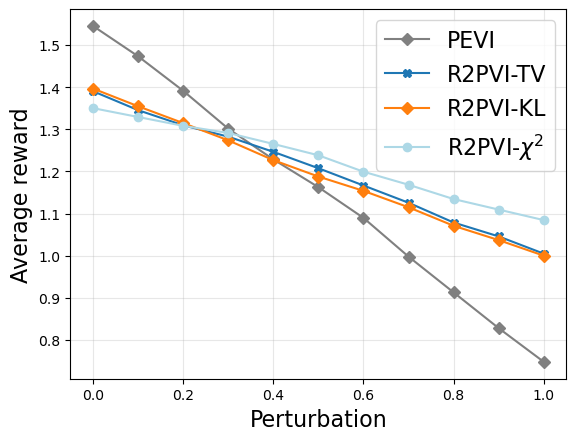

In [102]:
plt.plot(Perturbation, R_LSVI_LCB, label = 'PEVI', marker = 'D', color = 'gray')
#plt.fill_between(Perturbation, np.array(R_LSVI_LCB) - np.array(LSVI_LCB_std), np.array(R_LSVI_LCB) + np.array(LSVI_LCB_std), alpha=0.15)
plt.plot(Perturbation, R_SRPVI_TV, label = 'R2PVI-TV', marker = 'X')
#plt.fill_between(Perturbation, np.array(R_SRPVI_TV) - np.array(SRPVI_TV_std), np.array(R_SRPVI_TV) + np.array(SRPVI_TV_std), alpha=0.15)
plt.plot(Perturbation, R_SRPVI_KL, label = 'R2PVI-KL', marker = 'D')
#plt.fill_between(Perturbation, np.array(R_SRPVI_KL) - np.array(SRPVI_KL_std), np.array(R_SRPVI_KL) + np.array(SRPVI_KL_std), alpha=0.15)
plt.plot(Perturbation, R_SRPVI_xi2, label = r'R2PVI-$\chi^2$', marker = 'o', color = 'lightblue')
#plt.fill_between(Perturbation, np.array(R_SRPVI_xi2) - np.array(SRPVI_xi2_std), np.array(R_SRPVI_xi2) + np.array(SRPVI_xi2_std), alpha=0.15)
plt.legend(fontsize=16)
plt.grid(alpha=0.3)
plt.xlabel('Perturbation', size=16)
plt.ylabel('Average reward', size=16)
plt.savefig(f'compare_{delta}_{xi_norm}_{rho}.pdf', dpi=1000, bbox_inches='tight', pad_inches=0.0)

# figure 2

In [139]:
if __name__ == '__main__':
    T1 = 100
    H = 3
    rho = 0.2
    beta = 1
    lam = 0.1
    actions = list(product([-1, 1], repeat=4))
    action_space = [np.array(action) for action in actions]
    delta = 0.3
    xi_norm = 0.3
    fail_state = 'x4'
    replication = 20
    agent_dic = {}
    DR_agent_dic = {}
    VA_DR_agent_dic = {}
    SRPVI_TV_agent_dic = {}
    SRPVI_KL_agent_dic = {}
    SRPVI_xi2_agent_dic = {}
    env = LinearMDP_train(action_space, delta, xi_norm)

    for rep in range(replication):
        Offline_Dataset = Offline_Dataset_Collection(T1, env, seed=rep)
        agent = train_once_SRPVI_TV(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, rho=0.1, theta=env.theta, fail_state=fail_state)
        DR_agent = train_once_SRPVI_TV(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, rho=0.2, theta=env.theta, fail_state=fail_state)
        #VA_DR_agent = train_once_DR_VA(pre_agent=DR_agent, dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, Rho=Rho, theta=env.theta, fail_state=fail_state)
        
        SRPVI_TV_agent = train_once_SRPVI_TV(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, rho=0.3, theta=env.theta, fail_state=fail_state)
        
        SRPVI_KL_agent = train_once_SRPVI_TV(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, rho=0.6, theta=env.theta, fail_state=fail_state)
        SRPVI_xi2_agent = train_once_SRPVI_TV(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, rho=1, theta=env.theta, fail_state=fail_state)
        agent_dic[str(rep)] = agent
        
        DR_agent_dic[str(rep)] = DR_agent
        #VA_DR_agent_dic[str(rep)] = VA_DR_agent
        SRPVI_TV_agent_dic[str(rep)] = SRPVI_TV_agent
        SRPVI_KL_agent_dic[str(rep)] = SRPVI_KL_agent
        SRPVI_xi2_agent_dic[str(rep)] = SRPVI_xi2_agent
    
    Perturbation = [x / 10 for x in range(11)]
    T2 = 100
    R_LSVI_LCB = []
    LSVI_LCB_std = []
    R_DR_LSVI_LCB = []
    DR_LSVI_LCB_std = []
    #R_VA_DR_LSVI_LCB = []
    R_SRPVI_TV = []
    SRPVI_TV_std = []
    R_SRPVI_KL = []
    SRPVI_KL_std = []
    R_SRPVI_xi2 = []
    SRPVI_xi2_std = []
    env = LinearMDP_train(action_space, delta, xi_norm)
    for q in Perturbation:
        REWARD = []
        REWARD_DR = []
        #REWARD_DR_VA = 0
        REWARD_SRPVI_TV = []
        REWARD_SRPVI_KL = []
        REWARD_SRPVI_xi2 = []
        for rep in range(replication):
            reward = 0
            reward_DR = 0
            #reward_DR_VA = 0
            reward_SRPVI_TV = 0
            reward_SRPVI_KL = 0
            reward_SRPVI_xi2 = 0
            env_test = LinearMDP_test(env, q=q, seed=rep)
            env_test_DR = LinearMDP_test(env, q=q, seed=rep)
            #env_test_DR_VA = LinearMDP_test(env, q=q, seed=rep)
            env_test_SRPVI_TV = LinearMDP_test(env, q=q, seed=rep)
            env_test_SRPVI_KL = LinearMDP_test(env, q=q, seed=rep)
            env_test_SRPVI_xi2 = LinearMDP_test(env, q=q, seed=rep)
            agent = agent_dic[str(rep)]
            DR_agent = DR_agent_dic[str(rep)]
            #VA_DR_agent = VA_DR_agent_dic[str(rep)]
            SRPVI_TV_agent = SRPVI_TV_agent_dic[str(rep)]
            SRPVI_KL_agent = SRPVI_KL_agent_dic[str(rep)]
            SRPVI_xi2_agent = SRPVI_xi2_agent_dic[str(rep)]
            for t in range(T2):
                env_test.reset()
                env_test_DR.reset()
                #env_test_DR_VA.reset()
                env_test_SRPVI_TV.reset()
                env_test_SRPVI_KL.reset()
                env_test_SRPVI_xi2.reset()
                for h in range(H):
                # PEVI
                    current_state = env_test.current_state
                    phi_a = [env_test.phi(current_state, a) for a in action_space]
                    action = agent.get_action(phi_a, h)
                    env_test.step(action)
                # DRPVI
                    current_state_DR = env_test_DR.current_state
                    phi_DR_a = [env_test_DR.phi(current_state_DR, a) for a in action_space]
                    action_DR = DR_agent.get_action(phi_DR_a, h)
                    env_test_DR.step(action_DR)
                
                # SRPVI-TV
                    current_state_SDR = env_test_SRPVI_TV.current_state
                    phi_SDR_a = [env_test_SRPVI_TV.phi(current_state_SDR, a) for a in action_space]
                    action_SDR = SRPVI_TV_agent.get_action(phi_SDR_a, h)
                    env_test_SRPVI_TV.step(action_SDR)

                # SRPVI-KL
                    current_state_SDR = env_test_SRPVI_KL.current_state
                    phi_SDR_a = [env_test_SRPVI_KL.phi(current_state_SDR, a) for a in action_space]
                    action_SDR = SRPVI_KL_agent.get_action(phi_SDR_a, h)
                    env_test_SRPVI_KL.step(action_SDR)
                 
                # SRPVI-xi2
                    current_state_SDR = env_test_SRPVI_xi2.current_state
                    phi_SDR_a = [env_test_SRPVI_xi2.phi(current_state_SDR, a) for a in action_space]
                    action_SDR = SRPVI_xi2_agent.get_action(phi_SDR_a, h)
                    env_test_SRPVI_xi2.step(action_SDR)
                
                reward += np.sum(env_test.R) / T2
                reward_DR += np.sum(env_test_DR.R) / T2   
                #reward_DR_VA += np.sum(env_test_DR_VA.R) / T2 
                reward_SRPVI_TV += np.sum(env_test_SRPVI_TV.R) / T2
                reward_SRPVI_KL += np.sum(env_test_SRPVI_KL.R) / T2
                reward_SRPVI_xi2 += np.sum(env_test_SRPVI_xi2.R) / T2
            
            REWARD.append(reward)
            REWARD_DR.append(reward_DR) 
            #REWARD_DR_VA += reward_DR_VA / replication 
            REWARD_SRPVI_TV.append(reward_SRPVI_TV)
            REWARD_SRPVI_KL.append(reward_SRPVI_KL)
            REWARD_SRPVI_xi2.append(reward_SRPVI_xi2)
        
        R_LSVI_LCB.append(np.mean(REWARD))
        R_DR_LSVI_LCB.append(np.mean(REWARD_DR))
        #R_VA_DR_LSVI_LCB.append(REWARD_DR_VA)
        R_SRPVI_TV.append(np.mean(REWARD_SRPVI_TV))
        R_SRPVI_KL.append(np.mean(REWARD_SRPVI_KL))
        R_SRPVI_xi2.append(np.mean(REWARD_SRPVI_xi2))
        
        LSVI_LCB_std.append(np.std(REWARD))
        DR_LSVI_LCB_std.append(np.std(REWARD_DR))
        SRPVI_TV_std.append(np.std(REWARD_SRPVI_TV))
        SRPVI_KL_std.append(np.std(REWARD_SRPVI_KL))
        SRPVI_xi2_std.append(np.std(REWARD_SRPVI_xi2))


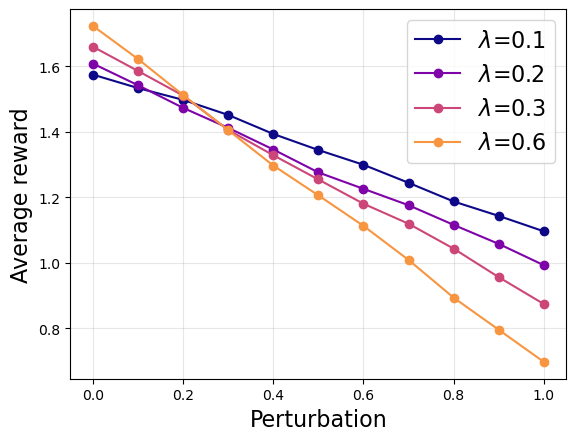

In [151]:
colors = plt.cm.plasma(np.linspace(0, 1, 5))
plt.plot(Perturbation, R_LSVI_LCB, label = r'$\lambda$=0.1', marker = 'o', color=colors[0])
#plt.fill_between(Perturbation, np.array(R_LSVI_LCB) - np.array(LSVI_LCB_std), np.array(R_LSVI_LCB) + np.array(LSVI_LCB_std), alpha=0.15)
plt.plot(Perturbation, R_DR_LSVI_LCB, label = r'$\lambda$=0.2', marker = 'o', color=colors[1])
plt.plot(Perturbation, R_SRPVI_TV, label = r'$\lambda$=0.3', marker = 'o', color=colors[2])
#plt.fill_between(Perturbation, np.array(R_SRPVI_TV) - np.array(SRPVI_TV_std), np.array(R_SRPVI_TV) + np.array(SRPVI_TV_std), alpha=0.15)
plt.plot(Perturbation, R_SRPVI_KL, label = r'$\lambda$=0.6', marker = 'o', color=colors[3])
#plt.fill_between(Perturbation, np.array(R_SRPVI_KL) - np.array(SRPVI_KL_std), np.array(R_SRPVI_KL) + np.array(SRPVI_KL_std), alpha=0.15)
#plt.plot(Perturbation, R_SRPVI_xi2, label = r'$\lambda$=0.6', marker = 'o')
#plt.fill_between(Perturbation, np.array(R_SRPVI_xi2) - np.array(SRPVI_xi2_std), np.array(R_SRPVI_xi2) + np.array(SRPVI_xi2_std), alpha=0.15)
plt.legend(fontsize=16)
plt.grid(alpha=0.3)
plt.xlabel('Perturbation', size=16)
plt.ylabel('Average reward', size=16)
plt.savefig(f'compare_{delta}_{xi_norm}_{rho}.pdf', dpi=1000, bbox_inches='tight', pad_inches=0.0)

# figure3

In [15]:
if __name__ == '__main__':
    T1 = 100
    H = 3
    beta = 1
    lam = 0.1
    actions = list(product([-1, 1], repeat=4))
    action_space = [np.array(action) for action in actions]
    delta = 0.3
    xi_norm = 0.2
    fail_state = 'x4'
    replication = 20

    env = LinearMDP_train(action_space, delta, xi_norm)
    rho_list = np.linspace(0, 1, 10)
    T2 = 100
    R_DR_LSVI_LCB, DR_std = [], []
    R_DR_KL, DR_KL_std = [], []
    R_SRPVI_TV, SDR_std = [], []
    R_SRPVI_KL, SRPVI_KL_std = [], []
    q = 0.9
    for rho in rho_list:
        print(rho)
        Rho = [[rho,rho,rho,rho], [rho, rho, rho, rho]]
        fail_state = 'x4'
        DR_agent_dic = {}
        DR_KL_agent_dic = {}
        SRPVI_TV_agent_dic = {}
        SRPVI_KL_agent_dic = {}
        env = LinearMDP_train(action_space, delta, xi_norm)
        env.reset()
        # train agents
        for rep in range(replication):
            Offline_Dataset = Offline_Dataset_Collection(T1, env, seed=rep)
            agent = train_once(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, fail_state=fail_state)
            DR_agent = train_once_DR(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, Rho=Rho, theta=env.theta, fail_state=fail_state)
            #DR_KL_agent = train_once_DR_LSVI_LCB_KL(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, Rho=Rho, theta=env.theta, fail_state=fail_state)
            SRPVI_TV_agent = train_once_SRPVI_TV(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, rho=rho, theta=env.theta, fail_state=fail_state)
            #SRPVI_KL_agent = train_once_SRPVI_KL(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, rho=rho, theta=env.theta, fail_state=fail_state)
            #agent_dic[str(rep)] = agent
            DR_agent_dic[str(rep)] = DR_agent
            #DR_KL_agent_dic[str(rep)] = DR_KL_agent
            SRPVI_TV_agent_dic[str(rep)] = SRPVI_TV_agent
            #SRPVI_KL_agent_dic[str(rep)] = SRPVI_KL_agent
        # test agents 
        REWARD_DR = []
        REWARD_SRPVI_TV = []
        #REWARD_DR_KL = []
        #REWARD_SRPVI_KL = []
        for rep in range(replication):

            reward_DR = 0
            reward_SRPVI_TV = 0  
            reward_DR_KL = 0
            reward_SRPVI_KL = 0  
            env_test_DR = LinearMDP_test(env, q=q, seed=rep)
            env_test_DR.reset()
            #env_test_DR_KL = LinearMDP_test(env, q=q, seed=rep)
            #env_test_DR_KL.reset()
            env_test_SRPVI_TV = LinearMDP_test(env, q=q, seed=rep)
            env_test_SRPVI_TV.reset()
            #env_test_SRPVI_KL = LinearMDP_test(env, q=q, seed=rep)
            #env_test_SRPVI_KL.reset()     

            DR_agent = DR_agent_dic[str(rep)]
            SRPVI_TV_agent = SRPVI_TV_agent_dic[str(rep)]
            #DR_KL_agent = DR_KL_agent_dic[str(rep)]
            #SRPVI_KL_agent = SRPVI_KL_agent_dic[str(rep)]
                
            for t in range(T2):
                env_test_DR.reset()
                env_test_SRPVI_TV.reset()
            #    env_test_DR_KL.reset()
            #    env_test_SRPVI_KL.reset()
                for h in range(H):
                    # DRPVI
                    current_state_DR = env_test_DR.current_state
                    phi_DR_a = [env_test_DR.phi(current_state_DR, a) for a in action_space]
                    action_DR = DR_agent.get_action(phi_DR_a, h)
                    env_test_DR.step(action_DR)
                    
                    
                    # SRPVI-TV
                    current_state_SDR = env_test_SRPVI_TV.current_state
                    phi_SDR_a = [env_test_SRPVI_TV.phi(current_state_SDR, a) for a in action_space]
                    action_SDR = SRPVI_TV_agent.get_action(phi_SDR_a, h)
                    env_test_SRPVI_TV.step(action_SDR)
                    
                    # DRPVI-KL
            #       current_state_DR_KL = env_test_DR_KL.current_state
            #        phi_DR_KL_a = [env_test_DR_KL.phi(current_state_DR_KL, a) for a in action_space]
            #        action_DR_KL = DR_KL_agent.get_action(phi_DR_KL_a, h)
            #        env_test_DR_KL.step(action_DR_KL)
                    
                    # SRPVI-KL
            #        current_state_SDR_KL = env_test_SRPVI_KL.current_state
            #        phi_SDR_KL_a = [env_test_SRPVI_KL.phi(current_state_SDR_KL, a) for a in action_space]
            #        action_SDR_KL = SRPVI_KL_agent.get_action(phi_SDR_KL_a, h)
            #        env_test_SRPVI_KL.step(action_SDR_KL)

                #print(np.sum(env_test_DR.R))
                reward_DR += np.sum(env_test_DR.R) / T2   
                reward_SRPVI_TV += np.sum(env_test_SRPVI_TV.R) / T2
            #    reward_DR_KL += np.sum(env_test_DR_KL.R) / T2
            #    reward_SRPVI_KL += np.sum(env_test_SRPVI_KL.R) / T2
            #print(reward_DR)        
            REWARD_DR.append(reward_DR) 
            #REWARD_DR_KL.append(reward_DR_KL)
            REWARD_SRPVI_TV.append(reward_SRPVI_TV)
            #REWARD_SRPVI_KL.append(reward_SRPVI_KL)
            
                
        R_DR_LSVI_LCB.append(np.mean(REWARD_DR))
        R_SRPVI_TV.append(np.mean(REWARD_SRPVI_TV))
        #R_DR_KL.append(np.mean(REWARD_DR_KL))
        #R_SRPVI_KL.append(np.mean(REWARD_SRPVI_KL))
        #DR_KL_std.append(np.std(REWARD_DR_KL))
        DR_std.append(np.std(REWARD_DR))
        SDR_std.append(np.std(REWARD_SRPVI_TV))
        #SRPVI_KL_std.append(np.std(REWARD_SRPVI_KL))
    

0.0


/tmp/ipykernel_26162/3467408839.py:447: RuntimeWarning: divide by zero encountered in divide
  w_h = Lambda_h_inverse @ Phi_h.T @ np.exp(-V_h_plus_one / rho)
/tmp/ipykernel_26162/3467408839.py:448: RuntimeWarning: divide by zero encountered in scalar divide
  return - rho * np.log(np.maximum(w_h, np.exp(-self.H/ rho)))
/tmp/ipykernel_26162/3467408839.py:448: RuntimeWarning: divide by zero encountered in log
  return - rho * np.log(np.maximum(w_h, np.exp(-self.H/ rho)))
/tmp/ipykernel_26162/3467408839.py:448: RuntimeWarning: invalid value encountered in multiply
  return - rho * np.log(np.maximum(w_h, np.exp(-self.H/ rho)))
/tmp/ipykernel_26162/3467408839.py:447: RuntimeWarning: invalid value encountered in divide
  w_h = Lambda_h_inverse @ Phi_h.T @ np.exp(-V_h_plus_one / rho)


0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


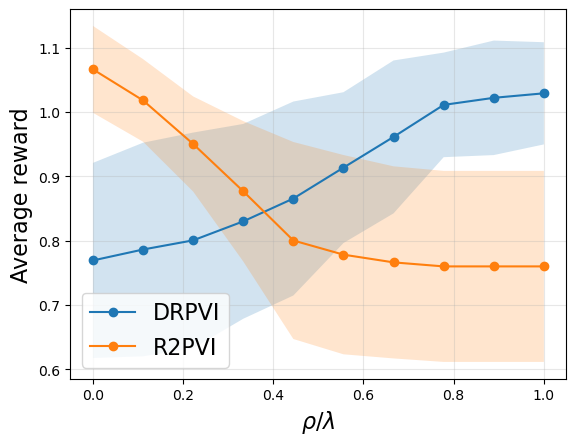

In [21]:
plt.plot(rho_list, R_DR_LSVI_LCB, label = 'DRPVI',marker = 'o')
plt.plot(rho_list, R_SRPVI_TV, label = 'R2PVI', marker = 'o')
#plt.plot(rho_list, R_DR_KL, label = 'DRPVI-KL')
#plt.plot(rho_list, R_SRPVI_KL, label = 'SRPVI-KL')
plt.fill_between(rho_list, np.array(R_DR_LSVI_LCB) - np.array(DR_std), np.array(R_DR_LSVI_LCB) + np.array(DR_std), alpha=0.2)
plt.fill_between(rho_list, np.array(R_SRPVI_TV) - np.array(SDR_std), np.array(R_SRPVI_TV) + np.array(SDR_std), alpha=0.2)
plt.grid(alpha=0.3)
plt.legend(fontsize=16)
plt.xlabel(r'$\rho / \lambda$', size=16)
plt.ylabel('Average reward', size=16)
plt.savefig(f'robustness.pdf', dpi=1000, bbox_inches='tight', pad_inches=0.0)

In [34]:
rho_list = np.linspace(0, 1,200)
print(rho_list.shape)

(200,)


NameError: name 'R_SRPVI_TV_VA' is not defined

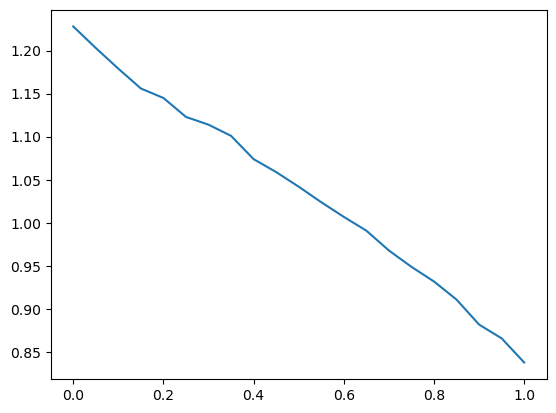

In [29]:
plt.plot(Perturbation, R_VA_DR_LSVI_LCB, label = 'VA-DRPVI')
plt.plot(Perturbation, R_SRPVI_TV_VA, label = 'SRPVI-TV-VA')
plt.grid(True) 
plt.legend(fontsize=16)
plt.xlabel('Perturbation', size=16)
plt.ylabel('Average reward', size=16)


In [1]:
plt.plot(Perturbation, R_DR_LSVI_LCB, label = 'DRPVI')
plt.plot(Perturbation, R_SRPVI_TV, label = 'SRPVI-TV')
plt.plot(Perturbation, R_SRPVI_KL, label = 'SRPVI-KL')
plt.plot(Perturbation, R_SRPVI_xi2, label = 'SRPVI-xi2')
plt.grid(True)
plt.legend(fontsize=16)
plt.xlabel('Perturbation_rho', size=16)
plt.ylabel('Average reward', size=16)

NameError: name 'plt' is not defined

# KL study

In [48]:
class DR_LSVI_LCB_KL():
    def __init__(self, A, beta, H, lam, dataset, Rho, theta, fail_state=None):
        self.lam = lam
        self.H = H
        self.action_space = A
        self.beta = beta
        self.w = [np.zeros(4) for _ in range(self.H)]
        self.Lambda = [self.lam * np.diag(np.ones(4)) for _ in range(self.H)]
        self.Rho = Rho
        self.theta = theta
        self.fail_state = fail_state
        self.dataset = dataset

    def get_action(self, phi_a, h):
        Q_h = [self.get_Q_func(phi_a[idx], h) for idx in range(len(self.action_space))]
        return self.action_space[np.argmax(Q_h)]

    def get_Q_func(self, phi, h, s_f=False):
        if s_f == True:
            return 0
        else:
            Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
            penalty = self.beta * np.sqrt(phi @ np.diag(np.diagonal(Lambda_h_inverse)) @ phi)
            Q_h = np.min([(self.w[h] @ phi - penalty), self.H - h])
            return Q_h

    def get_nu_h(self, h, rho):
        Lambda_h_inverse = np.linalg.inv(self.Lambda[h])
        nu_h = np.zeros(4)
        Phi_h = np.zeros((0,4))
        V_h_plus_one = np.zeros(0)
        for tau in range(self.dataset['k']):
            phi_tau_h = self.dataset['phi'][tau][h]
            Phi_h = np.vstack((Phi_h, phi_tau_h))
            phi_tau_h_plus_one = self.dataset['phi_a'][tau][h+1]
            s_f_h_plus_one = (self.dataset['state'][tau][h+1] == self.fail_state)
            Q_tau_h_plus_one = [self.get_Q_func(phi_tau_h_plus_one[idx], h+1, s_f_h_plus_one)
                                for idx in range(len(self.action_space))]
            V_tau_h_plus_one = np.max(Q_tau_h_plus_one)
            V_h_plus_one = np.hstack((V_h_plus_one, V_tau_h_plus_one))
        for i in range(4):
            def z_alpha_i(alpha):
                # compact formular for z
                z = Lambda_h_inverse @ Phi_h.T @ (np.exp(-V_h_plus_one / alpha) - 1)
                z_clipped = np.clip(z[i] + 1, a_min=1e-6, a_max=None)
                return alpha * np.log(z_clipped)  + alpha * rho[i]
            result = minimize(z_alpha_i, self.H/2, method='Nelder-Mead', bounds=[(1e-6, self.H)])
            nu_h[i] = - result.fun
            #print(nu_h[i])
        return nu_h

    def update_Q(self):
        # Backward induction
        self.w = [None for _ in range(self.H)] # innitialize weights w
        for h in range(self.H-1, -1, -1):
            # calculate Lambda_h
            for n in range(self.dataset['k']):
                feature_temp = self.dataset['phi'][n][h]
                self.Lambda[h] += np.outer(feature_temp, feature_temp)
            # update w_h
            w_h = np.zeros(4)
            nu_h = np.zeros(4)
            if h == self.H - 1:
                w_h = self.theta[h]
            else:
                nu_h = self.get_nu_h(h, rho=self.Rho[h])
                w_h = self.theta[h] + nu_h
            self.w[h] = w_h
            
def train_once_DR_LSVI_LCB_KL(dataset, action_space, beta, H, lam, Rho, theta, fail_state):
    agent = DR_LSVI_LCB_KL(A=action_space, beta=beta, H=H, lam=lam, dataset=dataset, Rho=Rho, theta=theta, fail_state=fail_state)
    agent.update_Q()
    return agent

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


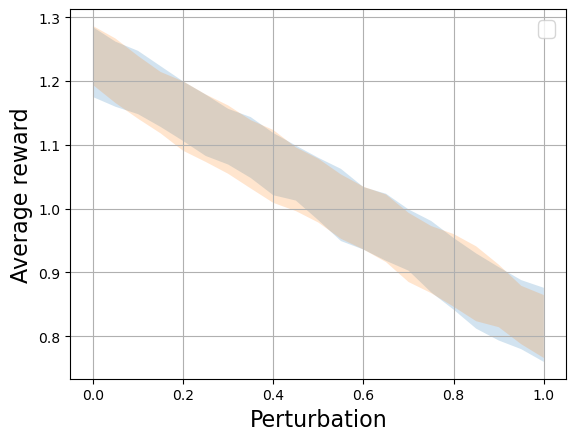

In [49]:
if __name__ == '__main__':
    T1 = 100
    H = 3
    rho = 0.2
    beta = 1
    lam = 0.1
    actions = list(product([-1, 1], repeat=4))
    action_space = [np.array(action) for action in actions]
    delta = 0.3
    xi_norm = 0.1
    Rho = [[0,0,0,rho], [0, 0, 0, 0]]
    fail_state = 'x4'
    replication = 20

    SRPVI_KL_agent_dic = {}
    DR_LSVI_LCB_KL_agent_dic = {}
    
    env = LinearMDP_train(action_space, delta, xi_norm)

    for rep in range(replication):
        Offline_Dataset = Offline_Dataset_Collection(T1, env, seed=rep)
        
        SRPVI_KL_agent = train_once_SRPVI_KL(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, Rho=Rho, theta=env.theta, fail_state=fail_state)
        DR_LSVI_LCB_KL_agent = train_once_DR_LSVI_LCB_KL(dataset=Offline_Dataset, action_space=action_space, beta=beta, H=H, lam=lam, Rho=Rho, theta=env.theta, fail_state=fail_state)

        SRPVI_KL_agent_dic[str(rep)] = SRPVI_KL_agent
        DR_LSVI_LCB_KL_agent_dic[str(rep)] = DR_LSVI_LCB_KL_agent
    
    Perturbation = [x / 20 for x in range(21)]
    T2 = 100

    R_SRPVI_KL, Sstd = [], []
    R_DR_LSVI_LCB_KL, Dstd = [], []
    env = LinearMDP_train(action_space, delta, xi_norm)
    for q in Perturbation:

        REWARD_SRPVI_KL = []
        REWARD_DR_LSVI_LCB_KL = []
        for rep in range(replication):

            reward_SRPVI_KL = 0
            reward_DR_LSVI_LCB_KL = 0
            

            env_test_SRPVI_KL = LinearMDP_test(env, q=q, seed=rep)
            env_test_DR_LSVI_LCB_KL = LinearMDP_test(env, q=q, seed=rep)

            SRPVI_KL_agent = SRPVI_KL_agent_dic[str(rep)]
            DR_LSVI_LCB_KL_agent = DR_LSVI_LCB_KL_agent_dic[str(rep)]
            
            for t in range(T2):
                
                env_test_SRPVI_KL.reset()
                env_test_DR_LSVI_LCB_KL.reset()
                
                for h in range(H):
                # SRPVI-KL
                    current_state_SDR = env_test_SRPVI_KL.current_state
                    phi_SDR_a = [env_test_SRPVI_KL.phi(current_state_SDR, a) for a in action_space]
                    action_SDR = SRPVI_KL_agent.get_action(phi_SDR_a, h)
                    env_test_SRPVI_KL.step(action_SDR)
                 
                # DRPVI-KL
                    current_state_SDR = env_test_DR_LSVI_LCB_KL.current_state
                    phi_SDR_a = [env_test_DR_LSVI_LCB_KL.phi(current_state_SDR, a) for a in action_space]
                    action_SDR = DR_LSVI_LCB_KL_agent.get_action(phi_SDR_a, h)
                    env_test_DR_LSVI_LCB_KL.step(action_SDR)
                

                reward_SRPVI_KL += np.sum(env_test_SRPVI_KL.R) / T2
                reward_DR_LSVI_LCB_KL += np.sum(env_test_DR_LSVI_LCB_KL.R) / T2
            
            REWARD_SRPVI_KL.append(reward_SRPVI_KL)
            REWARD_DR_LSVI_LCB_KL.append(reward_DR_LSVI_LCB_KL)
        
        R_SRPVI_KL.append(np.mean(REWARD_SRPVI_KL))
        R_DR_LSVI_LCB_KL.append(np.mean(REWARD_DR_LSVI_LCB_KL))
        Sstd.append(np.std(REWARD_SRPVI_KL))
        Dstd.append(np.std(REWARD_DR_LSVI_LCB_KL))
    
    plt.plot(Perturbation, R_DR_LSVI_LCB_KL, label = 'DRPVI-KL')
    plt.plot(Perturbation, R_SRPVI_KL, label = 'SRPVI-KL')
    plt.fill_between(Perturbation, np.array(R_DR_LSVI_LCB_KL) - np.array(Dstd), np.array(R_DR_LSVI_LCB_KL) + np.array(Dstd), alpha=0.2)
    plt.fill_between(Perturbation, np.array(R_SRPVI_KL) - np.array(Sstd), np.array(R_SRPVI_KL) + np.array(Sstd), alpha=0.2)
    plt.grid(True)
    plt.legend(fontsize=16)
    plt.xlabel('Perturbation', size=16)
    plt.ylabel('Average reward', size=16)
    plt.savefig(f'robustness_{delta}_{xi_norm}_{rho}.pdf', dpi=1000, bbox_inches='tight', pad_inches=0.0)

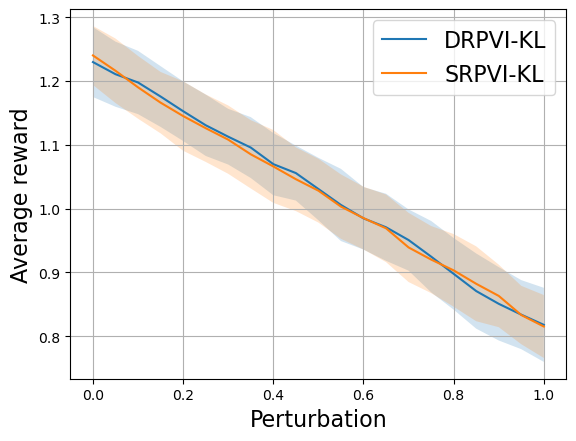

In [51]:
    plt.plot(Perturbation, R_DR_LSVI_LCB_KL, label = 'DRPVI-KL')
    plt.plot(Perturbation, R_SRPVI_KL, label = 'SRPVI-KL')
    plt.fill_between(Perturbation, np.array(R_DR_LSVI_LCB_KL) - np.array(Dstd), np.array(R_DR_LSVI_LCB_KL) + np.array(Dstd), alpha=0.2)
    plt.fill_between(Perturbation, np.array(R_SRPVI_KL) - np.array(Sstd), np.array(R_SRPVI_KL) + np.array(Sstd), alpha=0.2)
    plt.grid(True)
    plt.legend(fontsize=16)
    plt.xlabel('Perturbation', size=16)
    plt.ylabel('Average reward', size=16)
    plt.savefig(f'robustness_{delta}_{xi_norm}_{rho}.pdf', dpi=1000, bbox_inches='tight', pad_inches=0.0)

# plot results

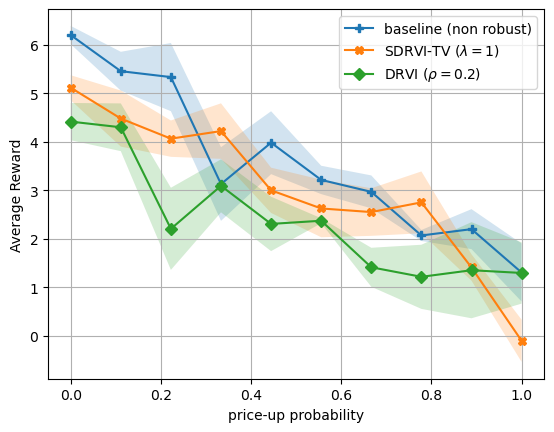

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# 示例数据
x = np.linspace(0, 1, 10)
y1 = 6 - 5 * x + np.random.normal(0, 0.5, len(x))
y2 = 5 - 4 * x + np.random.normal(0, 0.5, len(x))
y3 = 4 - 3 * x + np.random.normal(0, 0.5, len(x))

# 计算误差带
y1_err = np.random.normal(0.5, 0.2, len(x))
y2_err = np.random.normal(0.5, 0.2, len(x))
y3_err = np.random.normal(0.5, 0.2, len(x))

# 绘制图形
plt.figure()

plt.plot(x, y1, label='baseline (non robust)', marker = 'P')
plt.fill_between(x, y1 - y1_err, y1 + y1_err, alpha=0.2)

plt.plot(x, y2, label='SDRVI-TV ($\\lambda = 1$)', marker = 'X')
plt.fill_between(x, y2 - y2_err, y2 + y2_err, alpha=0.2)

plt.plot(x, y3, label='DRVI ($\\rho = 0.2$)', marker = 'D')
plt.fill_between(x, y3 - y3_err, y3 + y3_err, alpha=0.2)

# 添加标签和图例
plt.xlabel('price-up probability')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)

# 显示图形
plt.show()